In [280]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels
from statsmodels.stats.multitest import multipletests
from matplotlib.patches import PathPatch
from creme import utils


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [281]:
def adjust_box_widths(g, fac):
    """
    Adjust the withs of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])

In [282]:
pdf_base_dir = utils.make_dir('pdfs')
pdf_dir = utils.make_dir(f'{pdf_base_dir}/biochemistry/')
table_dir = utils.make_dir(f'../../results/summary_csvs/CRE_characterization/')
columns = ['Mean coverage', 'Max coverage']

In [340]:
histone_df, accessibility_df, tf_df = [pd.read_csv(f"../../results/biochemical_marks/{assay}.csv") 
                                      for assay in ['histone', 'accessibility', 'tf']]

In [342]:
histone_df[histone_df['epigenetic mark']=='H3K27ac'].groupby(['cell line', 'CRE type']).count()

Unnamed: 0  Mean coverage  Max coverage  CRE id  assay   
cell line CRE type                                                           
GM12878   Enhancer          41             41            41      41     41  \
          Neutral           49             49            49      49     49   
          Silencer          57             57            57      57     57   
K562      Enhancer          74             74            74      74     74   
          Neutral          148            148           148     148    148   
          Silencer         222            222           222     222    222   
PC-3      Enhancer          35             35            35      35     35   
          Neutral           66             66            66      66     66   
          Silencer          97             97            97      97     97   

                    epigenetic mark  track_id  
cell line CRE type                             
GM12878   Enhancer               41        41  
          Neutral                49        49  
          Silencer               57        57  
K562      Enhancer               74        74  
          Neutral               148       148  
          Silencer              222       222  
PC-3      Enhancer               35        35  
          Neutral                66        66  
          Silencer               97        97

# Histone marks

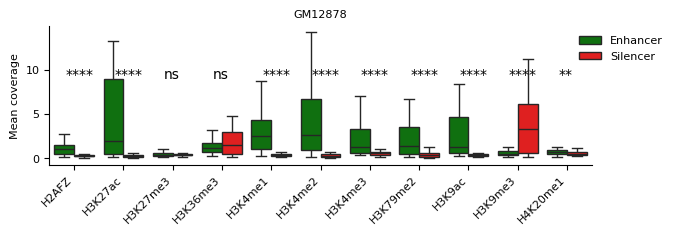

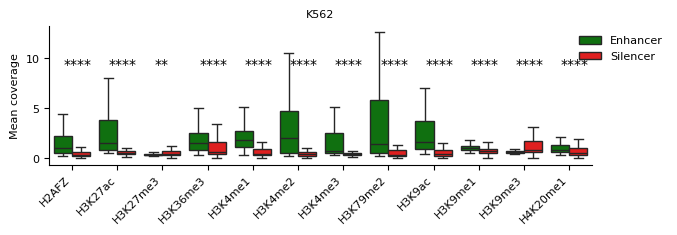

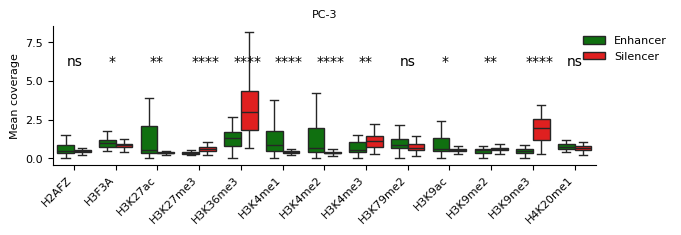

In [107]:
main_fig_histone_df = histone_df[histone_df['CRE type'] != 'Neutral']

fontsize=8
unique_marks = []
for cell_line, cell_line_hist_features in main_fig_histone_df.groupby('cell line'):
    mean_df = []
    for (mark, _), mark_df in cell_line_hist_features.groupby(['epigenetic mark', 'CRE id']):
        if mark_df.shape[0] > 1:
            mark_df['Mean coverage'] = mark_df['Mean coverage'].values.mean() # average if multiple cases of the same mark track
            mark_df['Max coverage'] = mark_df['Max coverage'].values.mean() # average if multiple cases of the same mark track

            mark_df = pd.DataFrame(mark_df.iloc[0]).T
            
        mean_df.append(mark_df)
    mean_df = pd.concat(mean_df)
    unique_marks.append(mean_df)

    column = 'Mean coverage'
    fig, axes = plt.subplots(1, figsize=[7,1.8])
    hist_order = sorted(mean_df['epigenetic mark'].unique())
    ax=sns.boxplot(data=mean_df.sort_values('CRE type'), x='epigenetic mark', y=column, hue='CRE type', showfliers=False,
                   order=hist_order,
                  palette={'Enhancer':'g', 'Silencer':'r', 'Neutral': 'blue'})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.set_title(cell_line)
    nobs = []
    for mark, df in mean_df.groupby('epigenetic mark'):
        # df = mean_df[mean_df['epigenetic mark'] == mark]
        if df.shape[0] > 0:
            annotation = utils.convert_pvalue_to_asterisks(scipy.stats.mannwhitneyu(df[df['CRE type']=='Enhancer'][column].values.astype(np.float32), 
                                                                               df[df['CRE type']=='Silencer'][column].values.astype(np.float32))[1])
            nobs.append(annotation)
        else:
            nobs.append('')
    pos = range(len(nobs))

    for tick,label in zip(pos, ax.get_xticklabels()):
        ax.text(pos[tick]-0.18,
                ax.get_yticks().max()*0.6,
                nobs[tick])
    plt.legend(bbox_to_anchor=[1.15,1], frameon=False, fontsize=fontsize)        
    plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    plt.setp(ax.get_yticklabels(), fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.xlabel('', fontsize=fontsize)
    plt.title(cell_line, fontsize=fontsize)
    plt.ylabel('Mean coverage', fontsize=fontsize)
    plt.xticks(rotation=45, ha='right')

    plt.savefig(f"{pdf_dir}/histone_marks_{column}_{cell_line}.pdf", bbox_inches='tight')
    plt.show()
    


# Accessibility

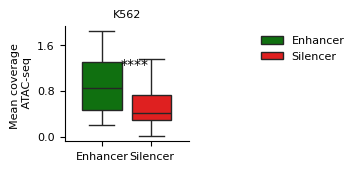

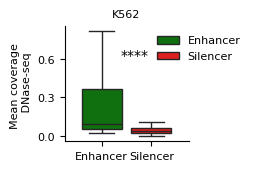

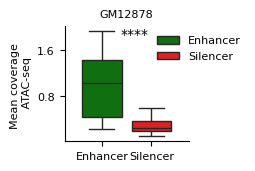

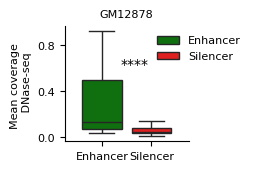

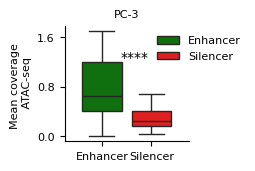

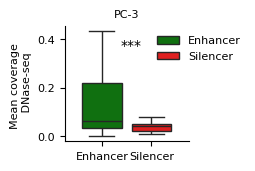

In [285]:

main_fig_accessibility_df = accessibility_df[accessibility_df['CRE type']!='Neutral']
                        
fontsize=8
unique_acc_df = {k:[] for k in columns}
column = 'Mean coverage'
unique_acc_df[column] = []
for cell_line in ['K562', 'GM12878', 'PC-3']:
    cell_line_acc_features = main_fig_accessibility_df[main_fig_accessibility_df['cell line']==cell_line]
    order = ['DNase-seq', 'ATAC-seq']

    mean_df = []
    for (mark, _), mark_df in cell_line_acc_features.groupby(['epigenetic mark', 'CRE id']):
        if mark_df.shape[0] > 1:
            mark_df[column] = mark_df[column].values.mean()
        mark_df = mark_df.iloc[0]
        mean_df.append(mark_df)
    mean_df = pd.DataFrame(mean_df)
    unique_marks.append(mean_df)
    unique_acc_df[column].append(mean_df)

    for acc_type, acc_df in mean_df.groupby('epigenetic mark'):
        fig, axes = plt.subplots(1, figsize=[1.6,1.5])
    
        ax=sns.boxplot(data=acc_df.sort_values('CRE type'), x='epigenetic mark', 
                       y=column, hue='CRE type', showfliers=False,width=0.8,
                       # order=order,
                      palette={'Enhancer':'g', 'Silencer':'r', 'Neutral': 'blue'})
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        #ax.set_title(cell_line)
        nobs = [utils.convert_pvalue_to_asterisks(scipy.stats.mannwhitneyu(acc_df[acc_df['CRE type']=='Enhancer'][column].values, 
                                                                     acc_df[acc_df['CRE type']=='Silencer'][column].values)[1])]

        pos = range(len(nobs))
        for tick,label in zip(pos, ax.get_xticklabels()):
            ax.text(pos[tick]-0.05,
                    ax.get_yticks().max()*0.6,
                    nobs[tick])
        plt.legend(bbox_to_anchor=[1.3,1])

        plt.setp(ax.get_xticklabels(), fontsize=fontsize)
        plt.setp(ax.get_yticklabels(), fontsize=fontsize)
        plt.yticks(fontsize=fontsize)
        plt.xticks([-.2, .2],['Enhancer', 'Silencer'], fontsize=fontsize)
        plt.xlabel('',fontsize=fontsize)
        plt.ylabel(f'Mean coverage \n {acc_type}', fontsize=fontsize)
        plt.legend(bbox_to_anchor=[1.5,1], frameon=False, fontsize=fontsize)    
        ax.set_title(cell_line, fontsize=fontsize)
        adjust_box_widths(fig, 0.8)
        
        ax.yaxis.set_major_locator(plt.MaxNLocator(3))

        plt.savefig(f"{pdf_dir}/accessibility_{acc_type}_{column}_{cell_line}.pdf", bbox_inches='tight')
        plt.show()
        
unique_acc_df[column] = pd.concat(unique_acc_df[column])

# TF

In [109]:
unique_tf_df = {}
for column in columns:
    unique_tf_df[column] = []
    for cell_line in ['K562', 'GM12878', 'PC-3']:
        cell_line_tf_features = tf_df[tf_df['cell line']==cell_line]
    
        mean_df = []
        for (mark, _), mark_df in cell_line_tf_features.groupby(['epigenetic mark', 'CRE id']):
            if mark_df.shape[0] > 1:
                mark_df[column] = mark_df[column].values.mean()
            mark_df = mark_df.iloc[0]
            mean_df.append(mark_df)
        mean_df = pd.DataFrame(mean_df)
        unique_marks.append(mean_df)

        unique_tf_df[column].append(mean_df)
    unique_tf_df[column] = pd.concat(unique_tf_df[column])

In [324]:
np.random.randint(1,10)

4

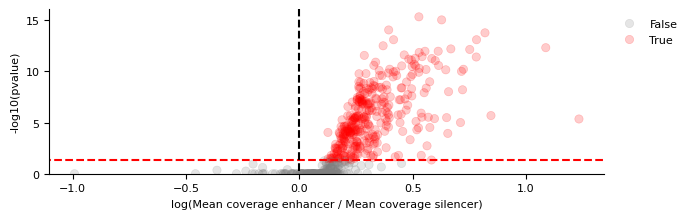

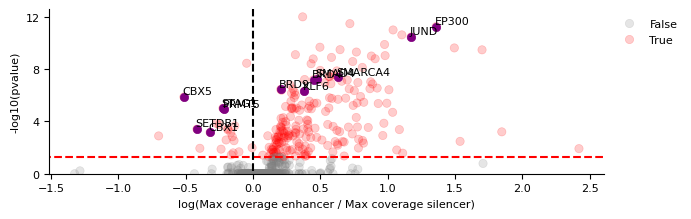

In [329]:
for column in columns:
    p_vals = []
    fcs = []
    logfc = []
    marks = []
    one_tf_df = unique_tf_df[column][unique_tf_df[column]['cell line']=='K562']
    for epi_mark, df in one_tf_df.groupby('epigenetic mark'):
        x = df[df['CRE type']=='Enhancer'][column].values
        y = df[df['CRE type']=='Silencer'][column].values
        p_val = scipy.stats.mannwhitneyu(x, y)[1]
        p_vals.append(p_val)
        logfc.append(np.log(x.mean()/y.mean()))
        fcs.append(x.mean()/y.mean())
        marks.append(epi_mark)
    
    res = statsmodels.stats.multitest.multipletests(p_vals, method='bonferroni')[1]
    adjusted_pvals = -np.log10(res)
    df = pd.DataFrame([fcs, logfc, adjusted_pvals, p_vals, marks]).T
    label = column.split()[0]
    df.columns =  ['enhancer / silencer', f'log({label} enhancer / {label} silencer)', '-log10(pvalue)', 'pvalue', 'mark']
    p_thresh = -np.log10(0.05)
    df['sign'] = [True if p> p_thresh else False for p in df['-log10(pvalue)'].values]
    color_dict = {True: 'red', False: 'grey'}
    
    fig, ax = plt.subplots(1, figsize=[7, 2.3])
    x = f'log({label} enhancer / {label} silencer)'
    y = '-log10(pvalue)'
    sns.scatterplot(data=df, x=x, y=y, ax=ax, alpha=0.2, hue='sign', palette=color_dict, edgecolor=None)
    p_thresh = -np.log10(0.05)
    xmin, xmax = ax.get_xlim()
    xmin, xmax = ax.get_xlim()
    plt.hlines(p_thresh, -xmax, xmax, linestyles='--', color='r')
    ymin, ymax = ax.get_ylim()
    

    plt.vlines(0, ymin, ymax, linestyles='--', color = 'k')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(0, ymax)
    ax.set_xlim(xmin, xmax)
    annotate_marks = [
        'CBX5', 'CBX1', 'SETDB1', 'PRMT5', 'STAG1',
                      'BRD4', 'BRD9',
                      'EP300', 
                      'JUND', 'KLF6',
                      # 'ETV6', 'KAT8', 'MAFK', 'MITF', 'MYC', 'RAD51', 'TRIM25', 'TEAD1',
                      'SMAD4', 'SMARCA4'
                         ]
    if 'Max' in column:
        for annotate_mark in annotate_marks:
            point = df[df['mark'] == annotate_mark]
            if point['sign'].values:
                sns.scatterplot(data=point, x=x, y=y, ax=ax, alpha=1, color='purple', edgecolor=None)
                plt.annotate(annotate_mark, (point[x].values-0.01, point[y].values+0.2), fontsize=fontsize)

    fontsize=8
    plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    plt.setp(ax.get_yticklabels(), fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.xlabel(f'log({label} coverage enhancer / {label} coverage silencer)',fontsize=fontsize)
    plt.ylabel('-log10(pvalue)', fontsize=fontsize)
    plt.legend(bbox_to_anchor=[1.15,1], frameon=False, fontsize=fontsize)        
    adjust_box_widths(fig, 0.8)
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))

    plt.tight_layout()
    plt.savefig(f"{pdf_dir}/TF_{column}_K562.pdf")
    plt.show()

In [111]:
df.sort_values('sign').to_csv(f'{table_dir}/pvalues_per_TF_for_sufficient_CREs.csv')

# Table of tracks

In [112]:
summary_dfs = []
for cell_line in ['K562', 'GM12878', 'PC-3']:
    for assay in ['accessibility', 'histone', 'tf']:
        if assay == 'tf' and cell_line in ['GM12878', 'PC-3']:
            pass
        else:
            df = pd.read_csv(f'../../data/biochemical_marks/{cell_line}/{assay}/metadata.csv')
            df = df[['File accession', 'Experiment accession', 'Assay', 'Experiment target', 'File assembly', 'Biosample term name', 'File download URL']]
            summary_dfs.append(df)
summary_dfs = pd.concat(summary_dfs)

In [10]:
summary_dfs.to_csv('../figures/pdfs/biochemistry/track_list.csv', index=None)

# Supplementary figures with neutral tile comparisons

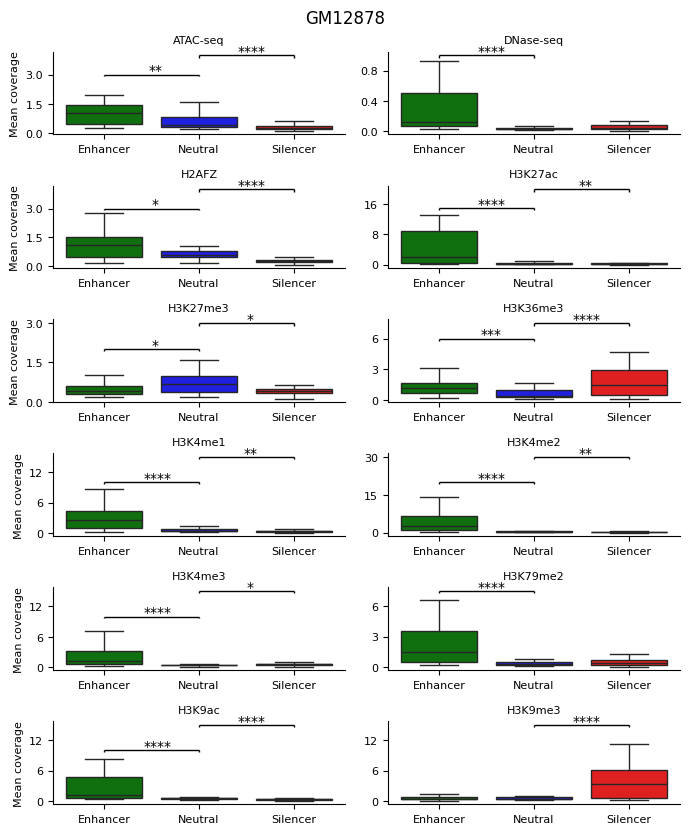

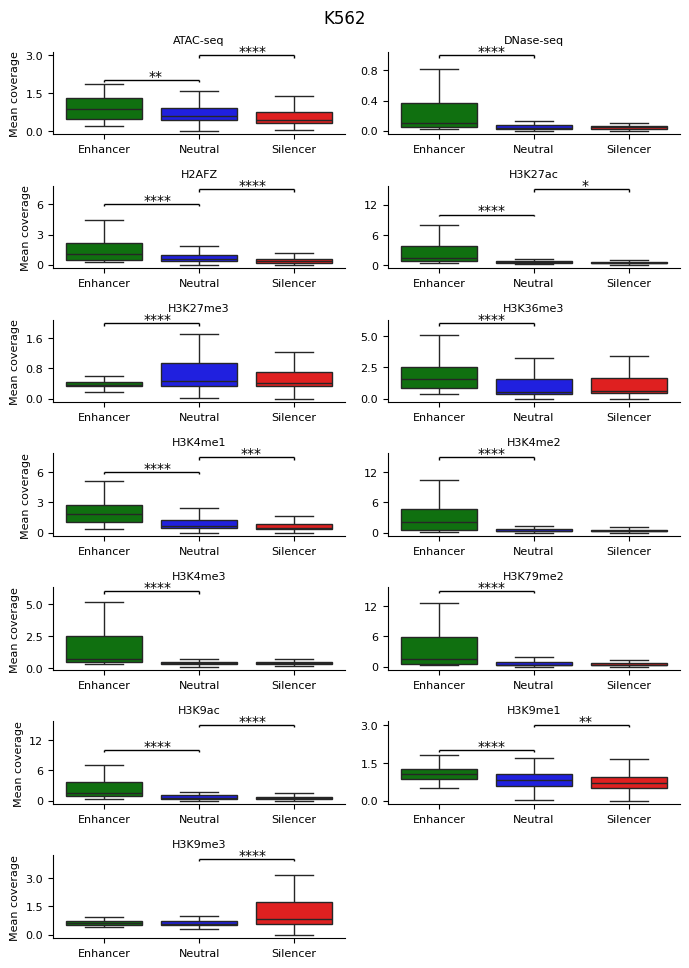

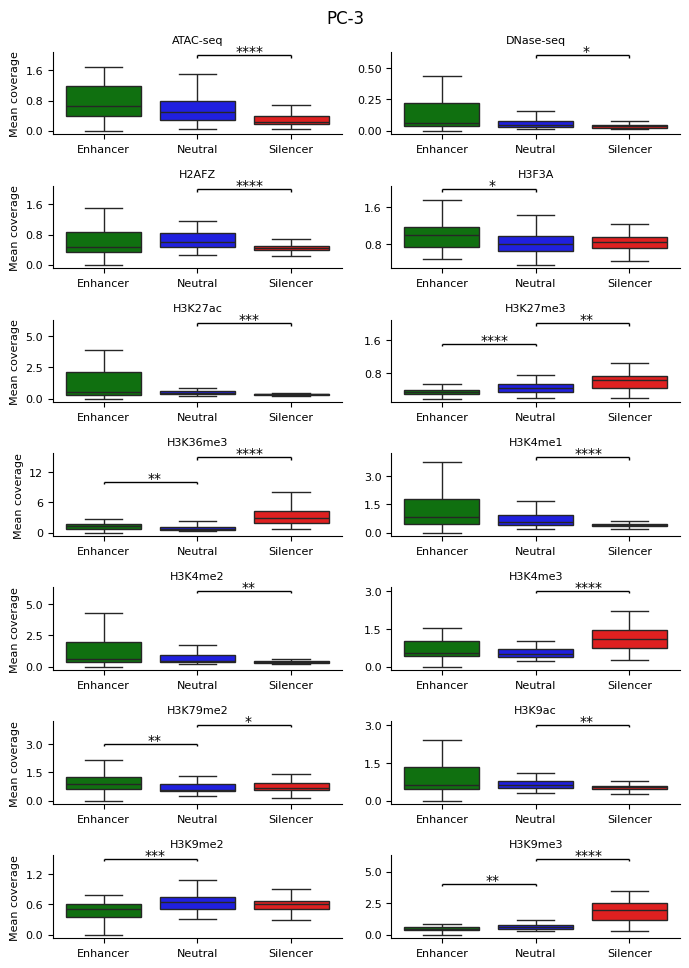

In [330]:
fontsize=8
unique_marks = []
pairs = [['Neutral', 'Silencer'], ['Neutral', 'Enhancer']]


for cell_line, cell_line_hist_features in pd.concat([histone_df, accessibility_df]).groupby('cell line'):
    fig, axes = plt.subplots(8, 2, figsize=[7, 11])
    axes = axes.reshape(-1)
    ax_N = 0
    mean_df = []
    for (mark, _), mark_df in cell_line_hist_features.groupby(['epigenetic mark', 'CRE id']):
        if mark_df.shape[0] > 1:
            mark_df['Mean coverage'] = mark_df['Mean coverage'].values.mean() # average if multiple cases of the same mark track
            mark_df['Max coverage'] = mark_df['Max coverage'].values.mean() # average if multiple cases of the same mark track

            mark_df = pd.DataFrame(mark_df.iloc[0]).T
            
        mean_df.append(mark_df)
    mean_df = pd.concat(mean_df)
    unique_marks.append(mean_df)

    column = 'Mean coverage'
   
    for last_axis, (mark, df) in enumerate(mean_df.groupby('epigenetic mark')):

        ax = axes[last_axis]
        sns.boxplot(df.sort_values('CRE type'), x='CRE type', y=column, showfliers=False, 
                                    hue='CRE type', ax=ax,
                                    palette={'Enhancer':'g', 'Silencer':'r', 'Neutral': 'blue'}
                   )
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        pairs = [['Neutral', 'Enhancer'],
                ['Neutral', 'Silencer']]
        
        
        nobs = [utils.convert_pvalue_to_asterisks(scipy.stats.mannwhitneyu(
                                                           df[df['CRE type']==p1][column].values.astype(np.float32), 
                                                           df[df['CRE type']==p2][column].values.astype(np.float32))[1]) for p1, p2 in pairs]
        
        pos = [0, 1]
         
        
        for tick, annotation in zip(pos, nobs):
            if annotation != 'ns':
                ymax = ax.get_yticks().max()
                ax.text(tick+0.5-(len(annotation)-1)*0.03,
                        ymax,
                        annotation)
                ax.hlines(ymax, tick, tick+1, color='k', linewidth=1)
                ax.vlines(tick, ymax, ymax*0.97, color='k', linewidth=1)
                ax.vlines(tick+1, ymax, ymax*0.97, color='k', linewidth=1)
        plt.setp(ax.get_xticklabels(), fontsize=fontsize)
        plt.setp(ax.get_yticklabels(), fontsize=fontsize)

        ax.tick_params(axis='x', labelsize=fontsize)
        ax.tick_params(axis='y', labelsize=fontsize)

        ax.set_xlabel('', fontsize=fontsize)
        if last_axis % 2 == 0:
            ax.set_ylabel('Mean coverage', fontsize=fontsize)
        else:
            ax.set_ylabel('')

        ax.set_title(mark, fontsize=fontsize)
        ax.yaxis.set_major_locator(plt.MaxNLocator(3))
    for j in range(last_axis, 16):
        axes[j].remove()
    plt.suptitle(cell_line)
    plt.tight_layout()
    plt.savefig(f"{pdf_dir}/suppl_histones_and_accessibility_with_neutrals_{cell_line}.pdf")
        
        
